# Hand Written Digit Classifier


## Working With Image Data

The aim of this project:

* observe the limitations of traditional machine learning models for image classification
* train, test, and improve a few different deep neural networks for image classification

The <font color='blue'>load_digits()</font> function returns a copy of the [hand-written digits dataset from UCI](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

In [1]:
#import libraries
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

digits_data = load_digits()

## 1. Exploring the data 

* Explore the data in <font color='blue'> digits_data</font>

In [2]:
digits_data.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

In [3]:
digits_data['data'][0]


array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [4]:
digits_data['target'][0]

0

* Each <font color='blue'>target</font> element is a digit value that corrensponded to vector represantion of its image pixel in each  <font color='blue'>data</font> element


##### Transform the NumPy 2D array into a pandas dataframe.


In [5]:
labels = pd.Series(digits_data['target'])

In [6]:
data = pd.DataFrame(digits_data['data'])
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


#### visualize some of the images in the dataset

* dataframes are a tabular representation of data, each image is represented as a row of pixel values.
* To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (8 x 8 pixels). For instance, to show the first element in <font color='blue'>data</font> we can do the following:


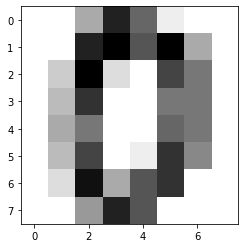

In [7]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

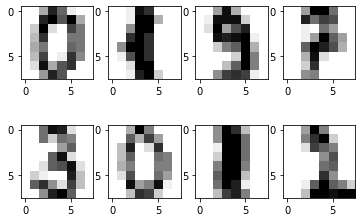

In [8]:
f, axarr = plt.subplots(2, 4)

indx = [0,99,199,299,999,1099,1199,1299]

for row in range(0,2):
    for col in range(0,4):

        axarr[row, col].imshow(data.iloc[indx[4*row+col]].values.reshape(8,8), cmap='gray_r')


## 2. Classical machine learning model
### K-Nearest Neighbors Model

* While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm make no such assumption. This allows them to capture nonlinearity in the data. 

* The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

#### Setup a pipeline for testing and training k-nn models

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# Train / test validation
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies
        
knn_one_accuracies = cross_validate(1)
np.mean(knn_one_accuracies)

0.9888728037614452

Experiment with different values for  <font color='red'>k</font> and plot the resulting classification accuracies.

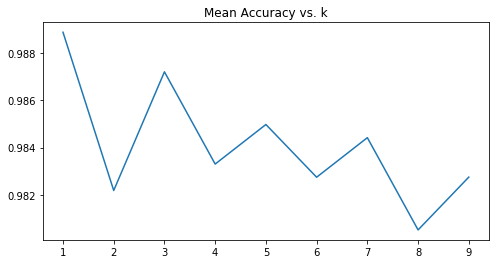

In [10]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)
    
plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. k")
plt.plot(k_values, k_overall_accuracies)

## 3. Deep Learning model

There are some drawbacks regarding to k-nearest neighbors:

* high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
* no model representation to debug and explore

Let's use a neural network. We use [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) package from scikit-learn.

#### Setup a pipeline for testing and training Neural Network models

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier

#  Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

### Neural Network With One Hidden Layer

Train and test a neural network model using a single hidden layer of 8,16,32,64,128,256 neurons.

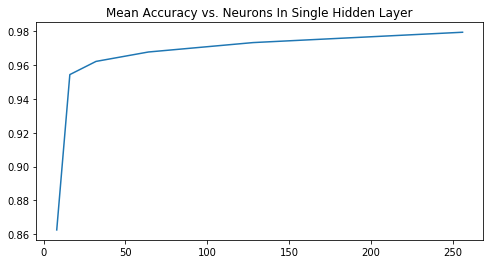

In [12]:
import warnings
warnings.filterwarnings('ignore') 
nn_one_neurons = [
    (8,),
    (16,),
    (32,),
    (64,),
    (128,),
    (256,)
]
nn_one_accuracies = []

for n in nn_one_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_one_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Single Hidden Layer")

x = [i[0] for i in nn_one_neurons]
plt.plot(x, nn_one_accuracies)

### Conlusion:

Adding more neurons to the single hidden layer improved simple accuracy to approximately `97%`. Simple accuracy computes the number of correct classifications the model made, but doesn't tell us anything about false or true positives or false or true negatives.


## Neural Network With Two Hidden Layers

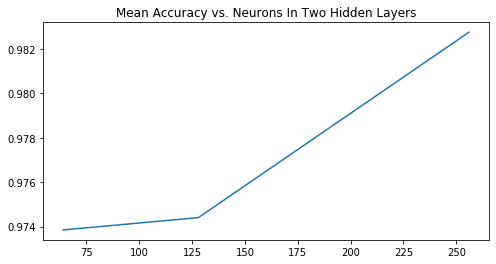

In [13]:
nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)
]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Two Hidden Layers")

x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies)

In [14]:
nn_two_accuracies

[0.973850532046523, 0.974404850284583, 0.9827530314278643]

### Summary

Using 2 hidden layers improved our simple accuracy to `98%`. Using 4-fold cross validation also gives us a bit more assurance that the model is generalizing to achieve the extra `1%` in simple accuracy over the single hidden layer networks we tried earlier.

## Neural Network With Three Hidden Layers

Modify the neural network training pipeline to use 6 fold cross validation instead.

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

# 50% Train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate_six(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 6, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

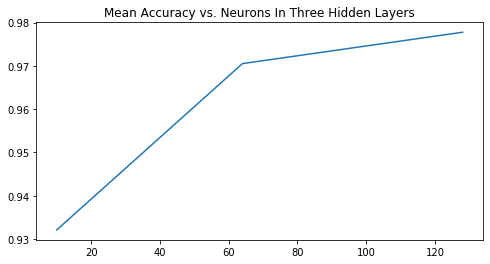

In [16]:
nn_three_neurons = [
    (10, 10, 10),
    (64, 64, 64),
    (128, 128, 128)
]

nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate_six(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

plt.figure(figsize=(8,4))
plt.title("Mean Accuracy vs. Neurons In Three Hidden Layers")

x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies)

In [17]:
nn_three_accuracies

[0.9321200297287254, 0.9705183946488294, 0.977755481233742]

### Summary

Using 3 hidden layers returned a simple accuracy of nearly `98%`, even with 6-fold cross validation. This seems to be in line with the research literature out there about deep neural networks for computer vision. Having more layers and more neurons tends to improve the network's performance.

## Future Work

* Use the existing pipeline you've built to try other machine learning models:
    * Decision Tree Models
    * Random Forest Models
* Write up a summary of the effectiveness of the different models you tried, with data to back up your conclusions.

* Experiment with different activation functions to see if the accuracies improve.

* Research some techniques for visualizing weights in neural network models and add a visualization step to your pipeline.
    * Visualization of [MLP Weights on MNIST](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html)
